In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
pd.options.plotting.backend = "plotly"
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 400)
pd.set_option("display.max_colwidth", None) # None for all of it
PARTYCOLORS =  {'AfD': '#59dcff', "CSU":"#525060", "CDU":"black", "SPD":"#e03427", "GRUENE":"#52d157", "DIE LINKE":"#a33ab5", "FDP":"#ffeb3b",}

In [14]:
dfg = pd.read_feather("germaparl_19_pg.feather")
dfg["last_name"] = dfg.name.str.split().str[-1]
dfg["speech_section"] = dfg["speech_section"].str.normalize('NFKD')

In [15]:
dfg.shape

(570716, 19)

In [16]:
dfg = dfg[dfg["role"]=="mp"]
dfg = dfg[~dfg["party"].str.contains("parteilos|LKR|Partei", case=False)]

In [17]:
dfg.party.unique()

array(['SPD', 'AfD', 'DIE LINKE', 'CDU', 'FDP', 'GRUENE', 'CSU'],
      dtype=object)

In [18]:
# Calculate total paragraphs per party
totalcount = dfg['party'].value_counts()
totalcount

CDU          57941
SPD          53429
AfD          45268
FDP          34280
GRUENE       33504
DIE LINKE    32745
CSU          21279
Name: party, dtype: int64

In [19]:
# Calculate number of paragraphs per party per session
party_speeches = dfg.groupby(['date', "party"])["name"].count().reset_index(name="count")

In [20]:
party_speeches.head(3)

,date,party,count
0,2017-10-24,AfD,16
1,2017-10-24,CDU,24
2,2017-10-24,CSU,1


In [21]:
# Calculate paragraphs per day
pg_count = dfg.value_counts("date", sort=False)

In [22]:
#dfg.loc[dfg["speech_section"].str.contains("energiev|energiew|Kohle|Atom|Kraftwerk|Solar|rneuerbar|indkraft|Abstandsregelung|EEG|Wasserstoff|Windrad|Stromgverbrauch|Stromerze|Strommix|Photovo|Strompreis|Erdgas")].shape

In [23]:
dfg = dfg[dfg["speech_section"].str.contains("Klimawandel|Klimapolitik|Klimakrise|Energiewende|Klimaschutz|klimafreundlich|menschengemacht", case=False)]

In [24]:
dfg.shape

(5691, 19)

In [355]:
dfg[["party", "who", "description_agenda", "speech_section"]].sample(2)

,party,who,description_agenda,speech_section
385838,CSU,Anja Weisgerber,Befragung der Bundesregierung,"Sehr geehrte Frau Bundeskanzlerin, die Themen Nachhaltigkeit und Klimaschutz spielen ja in der EU-Ratspräsidentschaft eine zentrale Rolle; das ist auch gut so. Klimaneutralität bis 2050 ist das Ziel für Europa. Deutschland geht mit dem Klimapaket ja mit gutem Beispiel voran. Wie motivieren wir die anderen Staaten Europas, hier mitzuziehen und nachzuziehen und auch die Klimaneutralität zu ihrem Ziel zu erklären?"
208837,DIE LINKE,Bernd Riexinger,Vereinbarte Debatte: Die Rolle Europas in einer Welt des Umbruchs,"Beim Klimaschutz ist es fünf vor zwölf. Um den Planeten zu retten, müssen jetzt europaweit Regeln für saubere Energie durchgesetzt werden. Spätestens 2030 müssen alle Kohlekraftwerke vom Netz und muss die regenerative Energie ausgebaut sein;"


In [356]:
print(party_speeches.head(1))
print(party_speeches2.head(1))

         date party  count
0  2017-10-24   AfD     16
         date party  count
0  2017-11-21   AfD     10


In [357]:
party_speeches2 = dfg.groupby(['date', "party"])["name"].count().reset_index(name="count")
partys = pd.merge(party_speeches, party_speeches2, left_on=['date','party'], right_on =['date','party'], how="left")
partys = partys.rename(columns={"count_x":"paragraphs_total", "count_y":"paragraphs_climate"})
partys["paragraphs_climate"].fillna(0, inplace=True)
partys["saliency"] = partys["paragraphs_climate"] / partys["paragraphs_total"]
partys.sample(8)

,date,party,paragraphs_total,paragraphs_climtate,saliency
929,2019-12-13,DIE LINKE,154,11.0,0.071429
1008,2020-02-13,GRUENE,195,5.0,0.025641
470,2018-11-30,CDU,351,3.0,0.008547
1497,2021-03-05,FDP,164,5.0,0.030488
1533,2021-04-15,GRUENE,195,3.0,0.015385
20,2017-11-22,SPD,125,0.0,0.000000
1286,2020-10-29,DIE LINKE,229,1.0,0.004367
581,2019-03-13,CSU,27,0.0,0.000000


In [359]:
## exclude dates where less than 6 partys spoke in the rolling mean
dates_few_partys = partys.groupby("date").party.count()[partys.groupby("date").party.count()<6].index.to_list()
partys = partys[~partys.date.isin(dates_few_partys)]

In [360]:
## Calculate rolling mean of climate saliency
partys = partys.sort_values(["date","party"])
rollingdf = pd.DataFrame(partys.set_index("date").groupby("party")["saliency"].rolling(30).mean()).reset_index()
rollingdf = rollingdf[~rollingdf["saliency"].isna()]

In [361]:
# Calculate relative saliency (saliency compared of each party as percentage of the total saliency)
saliency_sum = rollingdf.groupby("date")["saliency"].sum()
rollingdf["saliency_sum"] = rollingdf["date"].map(saliency_sum)
rollingdf["relative_saliency"] = rollingdf["saliency"] / rollingdf["saliency_sum"]
rollingdf.head(3)

,party,date,saliency,saliency_sum,relative_saliency
29,AfD,2018-05-15,0.011648,0.101030,0.115288
30,AfD,2018-05-16,0.011792,0.127431,0.092535
31,AfD,2018-05-17,0.010558,0.122912,0.085896


In [390]:
rollingdf[rollingdf["party"] == "GRUENE"].saliency.describe()

count    209.000000
mean       0.043596
std        0.010000
min        0.024508
25%        0.033854
50%        0.044808
75%        0.050882
max        0.065994
Name: saliency, dtype: float64

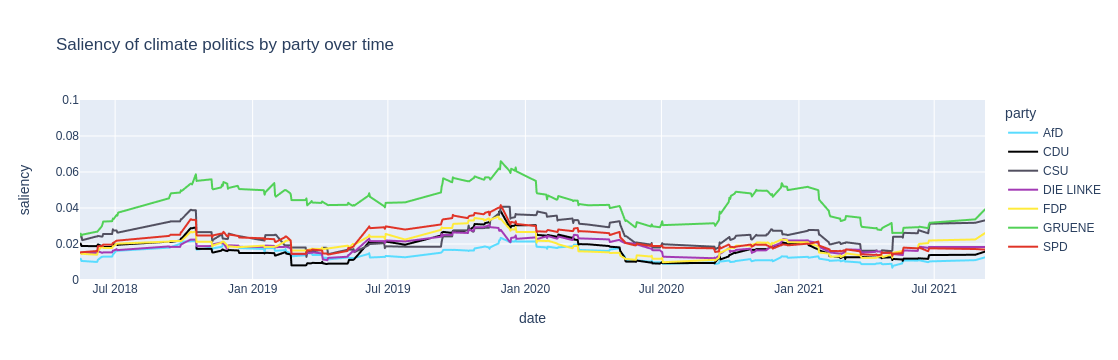

In [363]:
import plotly.express as px

fig = px.line(rollingdf, x="date", y="saliency", color='party', title="Saliency of climate politics by party over time", range_y=[0,0.1], color_discrete_map=PARTYCOLORS)
fig.show()

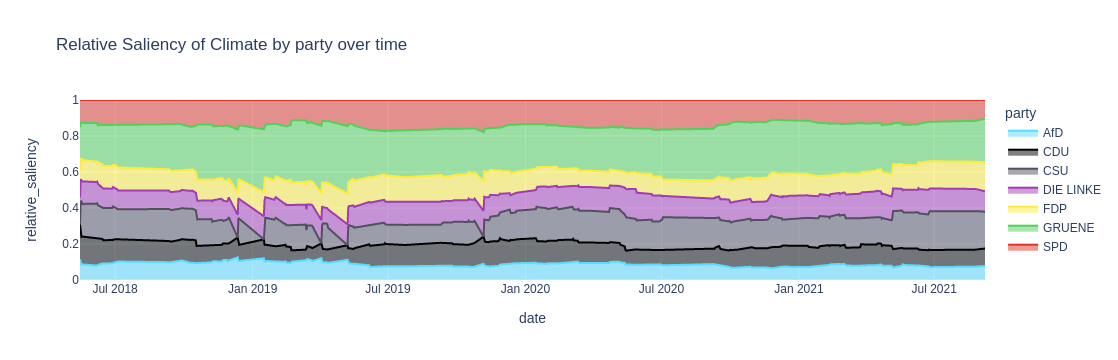

In [364]:
import plotly.express as px

fig = px.area(rollingdf, x="date", y="relative_saliency", color='party', title="Relative Saliency of Climate by party over time", range_y=[0,1], color_discrete_map=PARTYCOLORS)
fig.show()

In [365]:
## Count pargraphs per party again and convert number to dataframe
climatecount = dfg.value_counts("party")
totals = pd.DataFrame(totalcount.reset_index()).rename(columns={"party":"total_party", "index":"party"})
climatecount = pd.DataFrame(climatecount.reset_index()).rename(columns={0:"total_climate"})

In [366]:
# Calculate saliency of climate for the entire electoral term
climatecount = climatecount.merge(totals)
climatecount["saliency_climate"] = climatecount["total_climate"]/climatecount["total_party"]
climatecount

,party,total_climate,total_party,saliency_climate
0,GRUENE,1343,33504,0.040085
1,SPD,1093,53429,0.020457
2,CDU,883,57941,0.015240
3,FDP,651,34280,0.018991
4,DIE LINKE,611,32745,0.018659
5,AfD,600,45268,0.013254
6,CSU,510,21279,0.023967


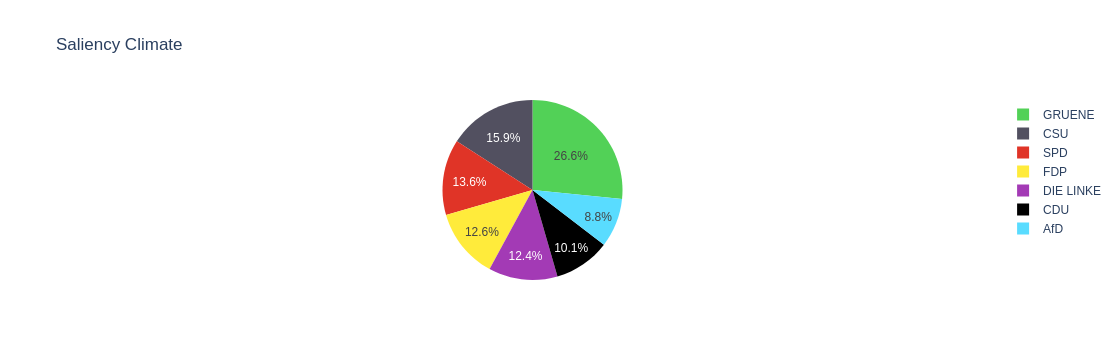

In [367]:
import plotly.express as px
fig = px.pie(climatecount, values='saliency_climate', names='party', title='Saliency Climate', color="party", color_discrete_map=PARTYCOLORS)
fig.show()

In [373]:
pg_count = pd.DataFrame(pg_count)
pg_count["category"] = "total"
pg_count.head()

,0,category
date,,
2017-10-24,110,total
2017-11-21,1150,total
2017-11-22,708,total
2017-12-12,1278,total
2017-12-13,1227,total


In [372]:
pg_count_cl = dfg.value_counts("date", sort=False)
pg_count_cl = pd.DataFrame(pg_count_cl)
pg_count_cl["category"] = "climate"
pg_count_cl.head()

,0,category
date,,
2017-11-21,54,climate
2017-12-12,8,climate
2017-12-13,3,climate
2018-01-17,5,climate
2018-01-18,46,climate


In [374]:
pg_count = pg_count.concat(pg_count_cl)

/tmp/ipykernel_61387/1448626636.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [379]:
pg_count = pg_count.reset_index()

In [381]:
pg_count

,date,0,category
0,2017-10-24,110,total
1,2017-11-21,1150,total
2,2017-11-22,708,total
3,2017-12-12,1278,total
4,2017-12-13,1227,total
...,...,...,...
461,2021-06-23,8,climate
462,2021-06-24,103,climate
463,2021-06-25,14,climate
464,2021-08-25,22,climate


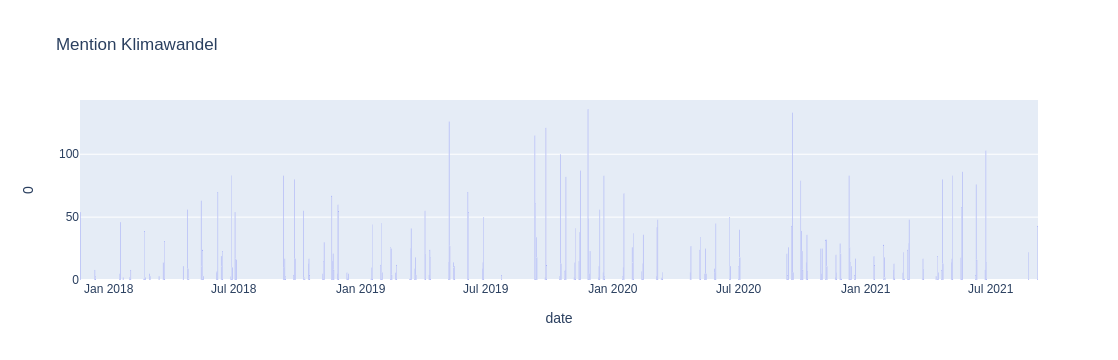

In [385]:
import plotly.express as px

fig = px.bar(pg_count_cl.reset_index(), x="date", y=0, title='Mention Klimawandel')
fig.show()